# Assignment 3 

Project Name: COSC102 - Assignment 3 – Machine Learning Portfolio: Comparing the Performance of Machine Learning Approaches for Activity Classification <br>
Authors: - <br>
Email: - <br>
Date: - 12/08/24<br>

BLOCK OF INFO EXPLAINING THE PROJECT AND WHAT WE WILL BE DOING.

In [120]:
# Import statements

import pandas as pd
import matplotlib.pyplot as plt

We will begin by laoding up our data sets and running through the beginning checklist of any data science project. This includes<br>
inspecting our data sets, checking for missing values and fixing any preliminary probelms we might see before moving onto the steps.

In [166]:
# function to load csv files as pandas dataframe

def load_data(csv, header, col_names):
    """
    Takes a csv's file path in the form of a string and 
    returns a pandas dataframe of the csv, if the dataset
    has no column names, it will append a passed in list
    of column names, otherwise it will leave the dataset 
    as is.
    Params:
    String - csv, string of the file path for a given csv
    header - Paramater deciding if the first row of the csv 
    are the column names or not, pass "infer" if you data
    set has column names and "None" if it doesn't
    names - A list of column names to assign to the dataset
    only if the headers parameter is "None", pass None for
    this parameter if your dataset already has column names.
    Returns:
    Pandas dataframe of our csv file
    """
    return pd.read_csv(csv, header=header, names=col_names)    

In [167]:
# File paths for our csv data sets
IMU_DATA = "./a3_imu_data.csv"
ACTIVITY_DATA = "./a3_activity_annotations.csv"

Looking at the raw csv files outside of the project, we noticed that the imu data set has no column names, we are going to need<br>
to assign the data set column names so that it is easier/possible to work with. The names chosen were taken from the assignments <br>
task sheet. The activity data already had column names assigned and accurate, so no work was neccersary on them.

In [168]:
# Initialing our datasets as pandas dataframes and assigning column names

# List of column namesColumn 
imu_col_names = ["timestamp", "x_axis_accel", "y_axis_accel", "z_axis_accel", "x_axis_gyro", "y_axis_gyro", "z_axis_gyro"]

# Loading our csv files, the imu set has no column names so we are passing in a list of names to add
# The activity dataset comes with names so we leave it as it is and pass in "None" for column names
imu_data_raw = load_data(IMU_DATA, None, imu_col_names)
activity_data_raw = load_data(ACTIVITY_DATA, "infer", None)

That should do the job, now let's look and see what our datasets look like, check for missing values, and plot a basic visualization<br> of the data sets.

In [169]:
# Function to check for any null values

def check_for_null(dataset, name):
    """
    Takes a pandas dataframe and the name of the dataframe as a string and
    checks if there are any missing values in all columns, prints out the 
    results
    Params:
    dataset - A pandas dataframe 
    name - A string for the name of your dataframe
    """
    print(f"{name}'s NULL values \n")
    for col in dataset.columns:
        print(f"{dataset[col].name} has {dataset[col].isnull().sum()} null values")

In [279]:
# Function to display a basic plot of our data

def plot_dataframe(X, y, title):
    """
    Takes an X and y from a pandas dataseries as well as the title in the form of a string. 
    The X value should be a single column of values from a pandas dataframe, the y values
    can contain as many columns as you like.
    Params:
    X - Pandas series containing the x value for our plot
    y - Pandas series containing the y value(s) for our plot
    title - String containing the desired title for our plot
    """
    # Create a figure
    fig, ax = plt.subplots(figsize=(16,8))

    # for every column in the y set, get the column name and append it to a list of labels
    
    labels=[i for i in y.columns]

    # Plot the data and add basic quality of life features
    plt.plot(X, y, label= labels)
    ax.set_xlabel(X.name, fontsize=18)
    ax.ticklabel_format(useOffset=False, style='plain')
    ax.set_ylabel("Values", fontsize=18)
    ax.set_title(title, fontsize=22)
    plt.grid()
    plt.legend()

### IMU Dataset Inspection

In [265]:
# Check for null values
check_for_null(imu_data_raw, "IMU DATA")


IMU DATA's NULL values 

timestamp has 0 null values
x_axis_accel has 0 null values
y_axis_accel has 0 null values
z_axis_accel has 0 null values
x_axis_gyro has 0 null values
y_axis_gyro has 0 null values
z_axis_gyro has 0 null values
time (seconds) has 0 null values


In [266]:
# Get basic information
imu_data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71242 entries, 0 to 71241
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   timestamp       71242 non-null  int64
 1   x_axis_accel    71242 non-null  int64
 2   y_axis_accel    71242 non-null  int64
 3   z_axis_accel    71242 non-null  int64
 4   x_axis_gyro     71242 non-null  int64
 5   y_axis_gyro     71242 non-null  int64
 6   z_axis_gyro     71242 non-null  int64
 7   time (seconds)  71242 non-null  int64
dtypes: int64(8)
memory usage: 4.3 MB


In [267]:
# Visualise the dataframe
imu_data_raw.head()

,timestamp,x_axis_accel,y_axis_accel,z_axis_accel,x_axis_gyro,y_axis_gyro,z_axis_gyro,time (seconds)
0,1598240213,-2402,1710,-380,-1413,-362,223,1
1,1598240213,-1880,1688,-420,-1469,-597,-23,1
2,1598240213,-1558,1568,-606,-1535,-872,-195,1
3,1598240213,-1154,1732,-654,-1293,-976,-335,1
4,1598240213,-452,2084,-754,-719,-940,-214,1


From above we can see that that our timestamps are calculated as unix time stamps, we might want to convert these to seconds before we plot <br>
the series to avoid some unpretty looking axis values. This will also come in handy later on in this project when aligning the two dataset.

In [268]:
# Assign the timestamp to a variable
time = imu_data_raw.timestamp

# Create a starting time outside of our loop so that it doesn't change value
# as we iterate through each value of the series
base_time = time[0]

# Iterate through every value of the timestamp column
for row in time:
    # Get the time in the timstamp column, minus the first value, and plus 1,
    # this will essentially count seconds from the start of the dataseries
    calc_seconds = row - base_time + 1
    # Take the value calculated above and replace it in our time column, this
    # will remove the unix timestamp from the column and replace it with the
    # difference in seconds since the start of the dataseries
    time = time.replace(to_replace=row, value=calc_seconds)

# Add the new time series to our dataframe
imu_data_raw["time (seconds)"] = time


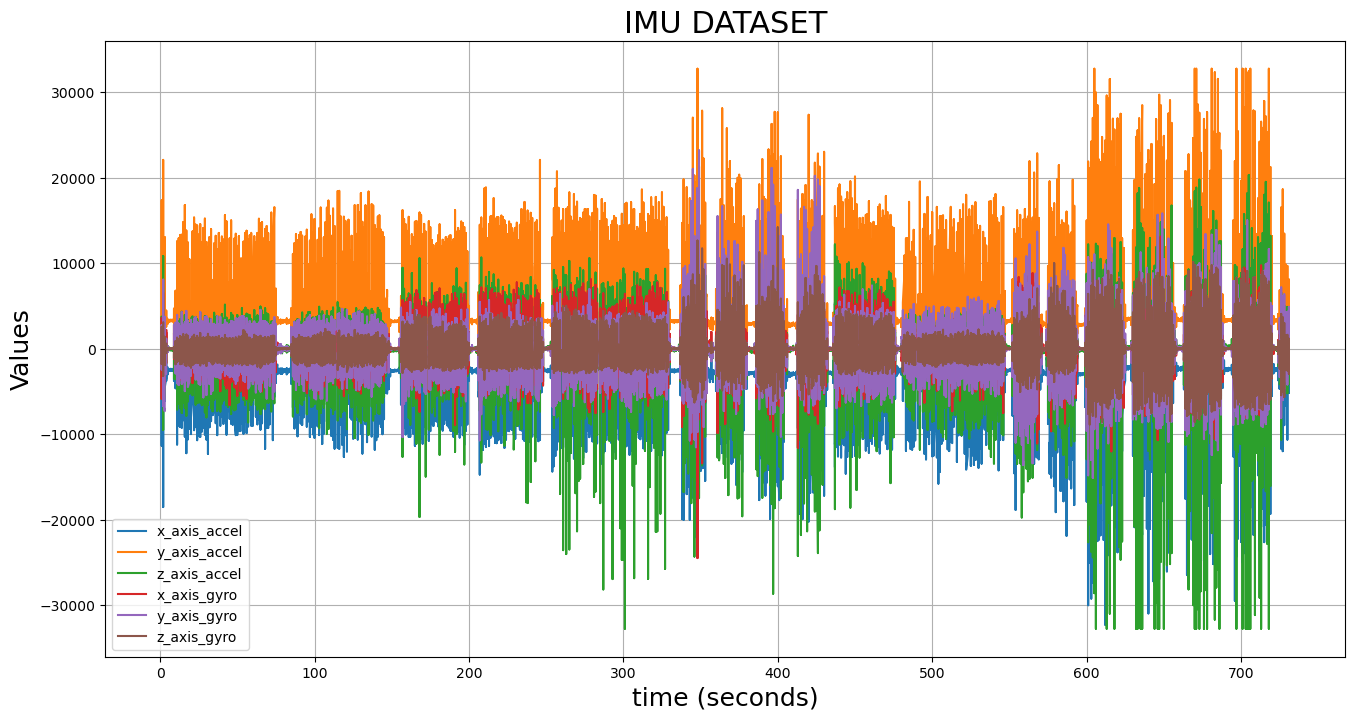

In [271]:
# Cal the plot_dataframe function passing it our dataframes timestamp column for the X axis and every other column for our y values

plot_dataframe(imu_data_raw["time (seconds)"],  imu_data_raw.drop(["timestamp", "time (seconds)"], axis=1), "IMU DATASET")

By the looks of it, our IMU dataset looks pretty straight forward:
- There are no null values
- We were able to correctly name the columns
- There are 71,000 samples of data
- All data values are integers
- The timestamp are unix time stamps
- We have created a new column value "time (seconds)" <br>
that tracks the time from the start of the data to <br>
any given point in seconds
<br>

Let's move onto our activity data set now and see what are working with and what we might have to fix

### Activity Dataset Inpection

In [282]:
check_for_null(activity_data_raw, "ACTIVITY DATA")

ACTIVITY DATA's NULL values 

image has 0 null values
xmin has 0 null values
ymin has 0 null values
xmax has 0 null values
ymax has 0 null values
label has 0 null values
time has 0 null values


In [283]:
activity_data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   image   34 non-null     object 
 1   xmin    34 non-null     float64
 2   ymin    34 non-null     float64
 3   xmax    34 non-null     float64
 4   ymax    34 non-null     float64
 5   label   34 non-null     object 
 6   time    34 non-null     float64
dtypes: float64(5), object(2)
memory usage: 2.0+ KB


In [284]:
activity_data_raw.head()

,image,xmin,ymin,xmax,ymax,label,time
0,a3.mp4#t=0.0,868.943127,417.331032,919.139168,557.535077,Walking,0.000000
1,a3.mp4#t=66.2,854.251592,330.392238,926.484935,564.882015,Standing,66.200000
2,a3.mp4#t=75.4,855.475924,324.882034,929.545709,561.820810,Walking,75.400000
3,a3.mp4#t=139.333333,849.966598,321.208565,928.933599,563.045281,Standing,139.333333
4,a3.mp4#t=146.733333,855.475924,327.331004,935.667145,553.249400,Jogging,146.733333


Similiarly like with the IMU dataset our Activity Dataset has a "not so straight forward" timestamp series, this is under the column named "image" and appears to <br>
be in the form of a string. We do need the time values from this set so that we can align our datasets later on. Fortunately it should be easy to create a clean<br>
set of data for time series from these values. Moving onto the other non-number series of data in the dataset, the labels. These will be our targets/labels/y-series<br>
that we will use to train our classifiers on later on, the rest of the data we don't need for this project. Let's fix our time series and then figure out what to plot.

In [ ]:
# Create a list to append our new time values too
time = []

# Iterate through every row of the "image" column
for row in activity_data_raw.image:
    # Split the row on the "=" and append only the second element as this is float
    # value that appears after the equals and not the a3.mp4# that appears before.
    time.append(float(row.split("=")[1]))

# Add the new series to our dataframe
activity_data_raw["time"] = time

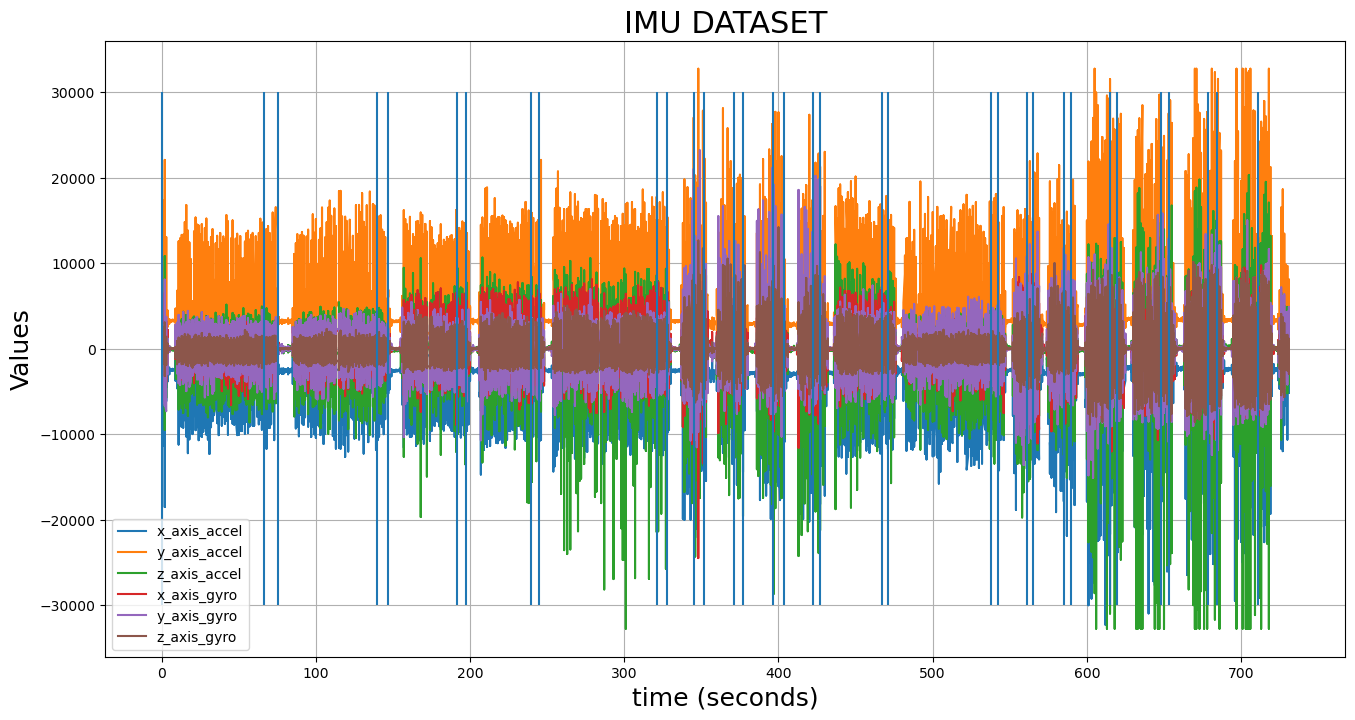

In [281]:
# Re-plot our IMU data and overlay the time points inthe activity dataset where the labels change
plot_dataframe(imu_data_raw["time (seconds)"],  imu_data_raw.drop(["timestamp", "time (seconds)"], axis=1), "IMU DATASET")

# Add vertical lines for every activity change
plt.vlines(activity_data_raw["time"], -30000,30000)
plt.show()

Ok, so from the plot above, it would appear that our imu data starts before our annotated video data and continues after afterwards aswell. To fix this we are going <br>
to have to slice up our imu data to make new start and stop points.


## Align and combine a dataset captured from an inertial sensor with an activity annotation file produced from a video recording of the data capture session.

## Visualize the combined dataset to check that the data has been correctly imported into Python and aligned with activity transitions.

## Process the activity annotation data to assign a target activity to each data point within the IMU dataset.

## Calculate a set of features from the raw sensor data.

## Apply a machine learning workflow to test a selection of classification algorithms on the feature set for the task of activity classification.

## Perform hyper-parameter optimization on at least one parameter for each algorithm.

## Create some visualizations and report on the model that your machine learning approaches have learned from the data.